# ChoCo Survey

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

from textwrap import wrap
from collections import Counter, OrderedDict

In [2]:
sns.set_theme(style="darkgrid")

In [3]:
survey_df = pd.read_csv("./chord_data_survey.csv")

questions = list(survey_df.columns)

In [4]:
def to_other(record, mappings:dict):
    for replace_str, with_str in mappings.items():
        record = record.replace(replace_str, with_str)
    return record

def otherise_answers(col_idx, mappings):
    if isinstance(mappings, list):
        mappings = {s: "Other" for s in mappings}
    return survey_df.iloc[:, col_idx].apply(
        to_other, mappings=mappings)

def split_answers(series):
    return series.str.get_dummies(sep=';')


In [5]:
def plot_cbar(question_df, col_index, figsize=(8,4),
              title_wrap=80, title_fs=16, ax=None, lab_wrap=25, tick_fs=16):

    if ax is None:
            _, ax = plt.subplots(figsize=figsize)

    cnt_df = pd.DataFrame(question_df.sum(), columns=["count"])
    cnt_df.index.name = "answer"  # from index to answer
    cnt_df = cnt_df.reset_index()  # just needed for plotting
    ax = sns.barplot(y="answer", x="count", data=cnt_df, ax=ax, orient="h")
    ax.set_title("\n".join(wrap(questions[col_index], title_wrap)), size=title_fs)
    ax.set_xticks(range(0, question_df.sum().max()+2))
    ax.set_ylabel("")  # remove 'answer' label for convenience

    new_xtick_labels = []
    for answer in ax.get_yticklabels():
        unwrapped_txt = answer.get_text()
        wrapped_txt = "\n".join(wrap(unwrapped_txt, lab_wrap))
        new_xtick_labels.append(wrapped_txt)
    assert(len(new_xtick_labels)==len(ax.get_yticklabels()))
    ax.set_yticklabels(new_xtick_labels, fontsize=tick_fs)

    return ax


def question_countplot(col_index:int, col="darkcyan", title_wrap=80):

    ax = sns.countplot(survey_df.iloc[:, col_index], color=col)
    pcts = Counter(survey_df.iloc[:, col_index])
    pcts = OrderedDict(sorted(pcts.items()))
    n = sum(pcts.values())
    pcts = [cnt/n*100 for cnt in list(pcts.values())]

    ax.set_title("\n".join(wrap(questions[col_index], title_wrap)))
    ax.set_xlabel("")  # remove question from the x-axis
    # ax.set_yticks(list(ax.get_yticks())+[ax.get_yticks()[-1]+1])

    patches = ax.patches
    for i in range(len(patches)):  # append percentages
        x = patches[i].get_x() + patches[i].get_width()/2
        y = patches[i].get_height()+.05
        ax.annotate('{:.1f}%'.format(pcts[i]), (x, y), ha='center')

    return ax


def question_barplot(col_index:int, col="darkcyan", title_wrap=80,
                     verbose=False, title_fs=16, ax=None):

        if ax is None:
            _, ax = plt.subplots()
        # Count the number of occurrences and fill missing items
        counts = Counter(survey_df.iloc[:, col_index])
        counts = {v: counts.get(v, 0) for v in range(1,6)}
        votes = sum(counts.values())  # sure these are exclusive
        pcts = [cnt/votes*100 for cnt in list(counts.values())]

        ax = sns.barplot(
            x=list(counts.keys()),
            y=list(counts.values()),
            color=col, ax=ax)

        ax.set_title("\n".join(wrap(questions[col_index], title_wrap)),
                     size=title_fs)
        ax.set_ylabel("count")
        if verbose:  # explain Likert scale if verbose
            ax.set_xticklabels([
                "1\n(strongly disagree)",
                "", "3\(nneutral)", "",
                "5\n(strongly agree)"])

        patches = ax.patches
        for i in range(len(patches)):  # append percentages
            x = patches[i].get_x() + patches[i].get_width()/2
            y = patches[i].get_height()+.05
            ax.annotate('{:.1f}%'.format(pcts[i]), (x, y), ha='center')

        return ax

# Questions 1-3

<AxesSubplot:xlabel='count'>

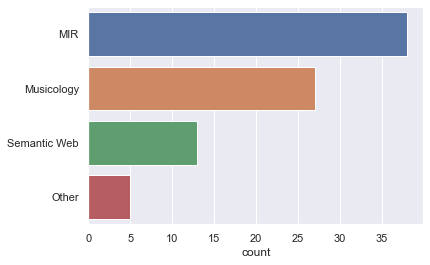

In [6]:
import itertools

# to_other = ["AI", "music theory", "Other", "Music interaction",
#             "Music economics and music sociology"]
to_mir  = ["Music Information Retrieval (MIR)",
           "Generative Music", "Music technology"]
to_sweb = ["Digital library", "Semantic Web"]
to_musi = ["Musicology", "Computational Musicology",
           "Perceived rhyrthmic relationships in  improvisational polytemporal settings"]

raw_replies = [r.split(";") for r in survey_df.iloc[:,1]]
raw_replies = list(itertools.chain.from_iterable(raw_replies))

new_replies = []
for old_reply in raw_replies:
    if old_reply in to_mir:
        new_replies.append("MIR")
    elif old_reply in to_sweb:
        new_replies.append("Semantic Web")
    elif old_reply in to_musi:
        new_replies.append("Musicology")
    else:  # renaming everything else to other
        new_replies.append("Other")

# raw_replies

sns.countplot(y=new_replies)

In [7]:
mapping_to_other = {
    "Chord sequences in human readable notations, Audio, midi": "Audio music;Symbolic music (e.g. MusicXML)",
    "Marc, Json": "Other",  # question not understood
    "Tablatures": "Symbolic music (e.g. MusicXML)",
    "bibliographic data": "Other",  # question not understood
    "working directly with f0 contours drawn from audio": "Audio music",
    "Audio for ethnographic studies": "Audio music",
    "Biographies of artists": "Other",
    "Images of sheet music": "Other",
    "I teach Japanese for IT experts who speak English and Greek and use songs in my lessons in combination with meditation": "Other",
}

q2 = split_answers(otherise_answers(2, mapping_to_other))
q2 = q2.iloc[:, [0, 3, 1, 2]]

q2.sum()


Audio music                                  29
Symbolic music (e.g. MusicXML)               33
Both, jointly (e.g. multi-modal analyses)    18
Other                                         5
dtype: int64

<AxesSubplot:title={'center':'My work on content-based music data focuses, or will focus, on:'}, xlabel='count'>

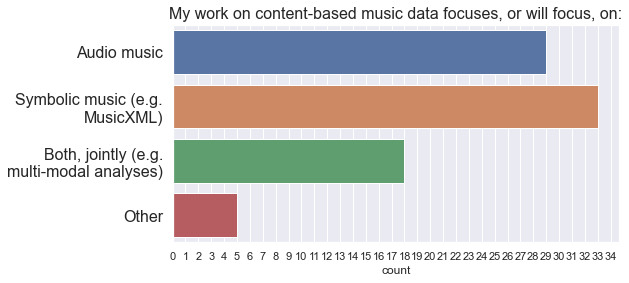

In [8]:
plot_cbar(q2, col_index=2)

In [9]:
mapping_to_other = {
    "This is not entirely clear to me. Is it a matter of specifying here the sources likely to shed light on the musical context explored through the data (audio or symbolic). If so, the paper format should definitely be added and the answers should not be limited to web data only. ": "Other",
    " data from surveys": "Structured data (e.g CSV, JSON, etc.)",  # question not understood
    "MEI, MIDI,": "Other", # question not understood
    "expert labelled data": "Other",  # question not understood
    "motion data, spatial analyses of harmony": "Other",
    "Doremus data": "RDF data",
    "MEI, Lilypond, MusicXML and MIDI": "Other",  # question not understood
    "Marc an d METS records (bibliographical and digital objects metadata)": "Structured data (e.g CSV, JSON, etc.)",
    "I am a certified Full Stack Front End developer - trying to undrestand how to optimize my webpage creation knowledge to support cultural language professional education projects and beyond": "Other",  # question not understood
    "Primary data collection from artists and audience": "Other"
}

q3 = split_answers(otherise_answers(3, mapping_to_other))
q3 = q3.iloc[:, [2, 3, 4, 0, 1]]

q3.sum()

RDF data                                                       13
Structured data (e.g CSV, JSON, etc.)                          46
Unstructured data from the Web (e.g. text, web pages, etc.)    24
Databases (e.g. MusicBrainz, Genius, etc.)                     24
Other                                                           7
dtype: int64

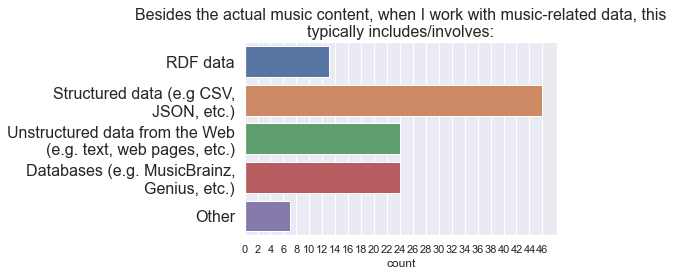

In [10]:
plot_cbar(q3, col_index=3, lab_wrap=30)
plt.xticks(np.arange(0, q3.sum().max() + 2, 2.0))

plt.tight_layout()
plt.savefig("survey_background_b.pdf")

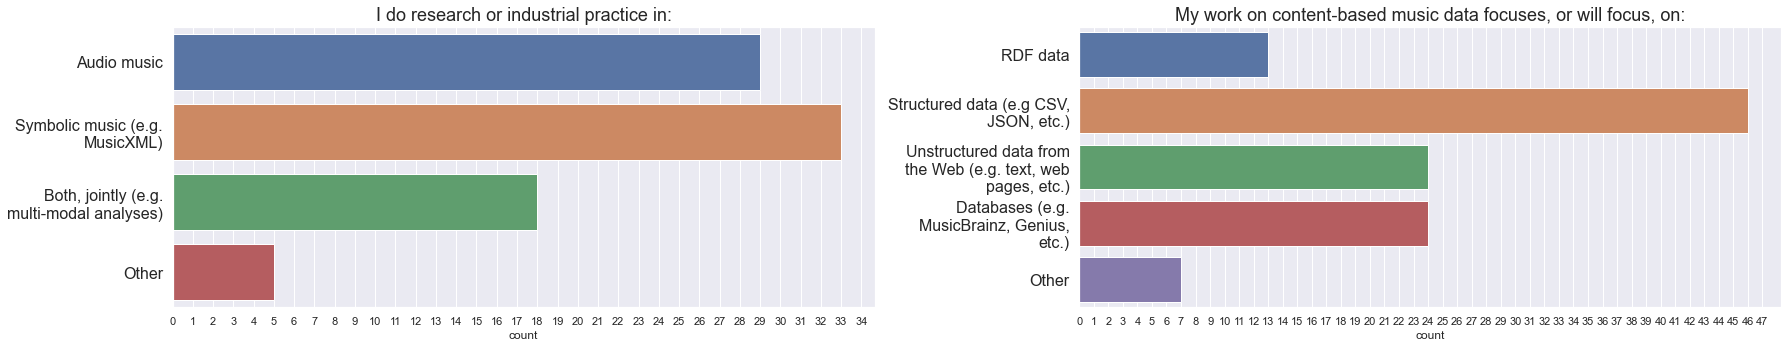

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25,5))
ax = plot_cbar(q2, col_index=1, ax=axes[0], tick_fs=16, title_fs=18)
plot_cbar(q3, col_index=2, ax=axes[1], title_fs=18)


plt.tight_layout()
plt.savefig("survey_background_dtype.pdf")

# Questions 3-10

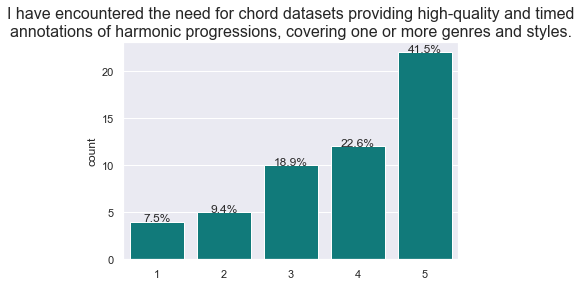

In [12]:
ax = question_barplot(4)

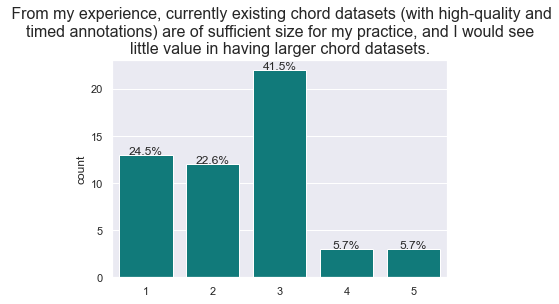

In [13]:
ax = question_barplot(5)

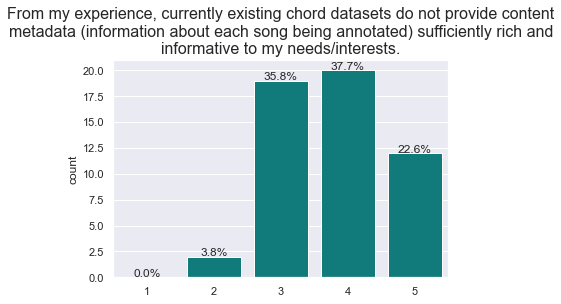

In [14]:
ax = question_barplot(6)


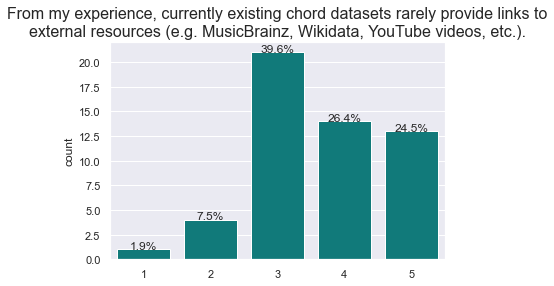

In [15]:
ax = question_barplot(7)

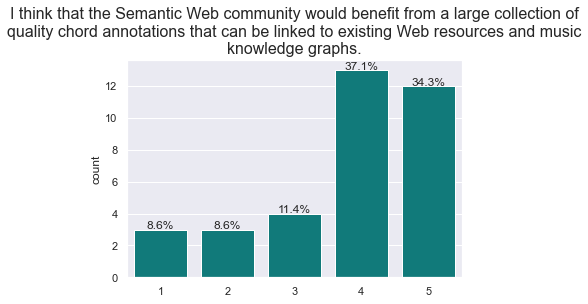

In [16]:
ax = question_barplot(8)


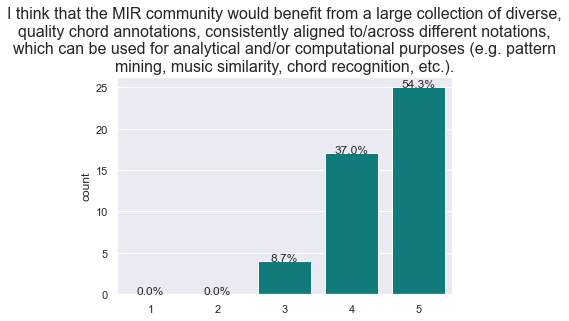

In [17]:
ax = question_barplot(9)

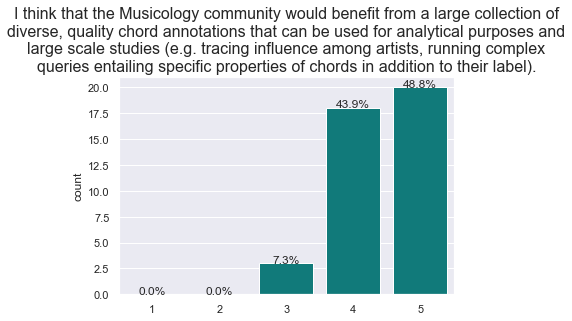

In [18]:
ax = question_barplot(10)

## All evidence plots together

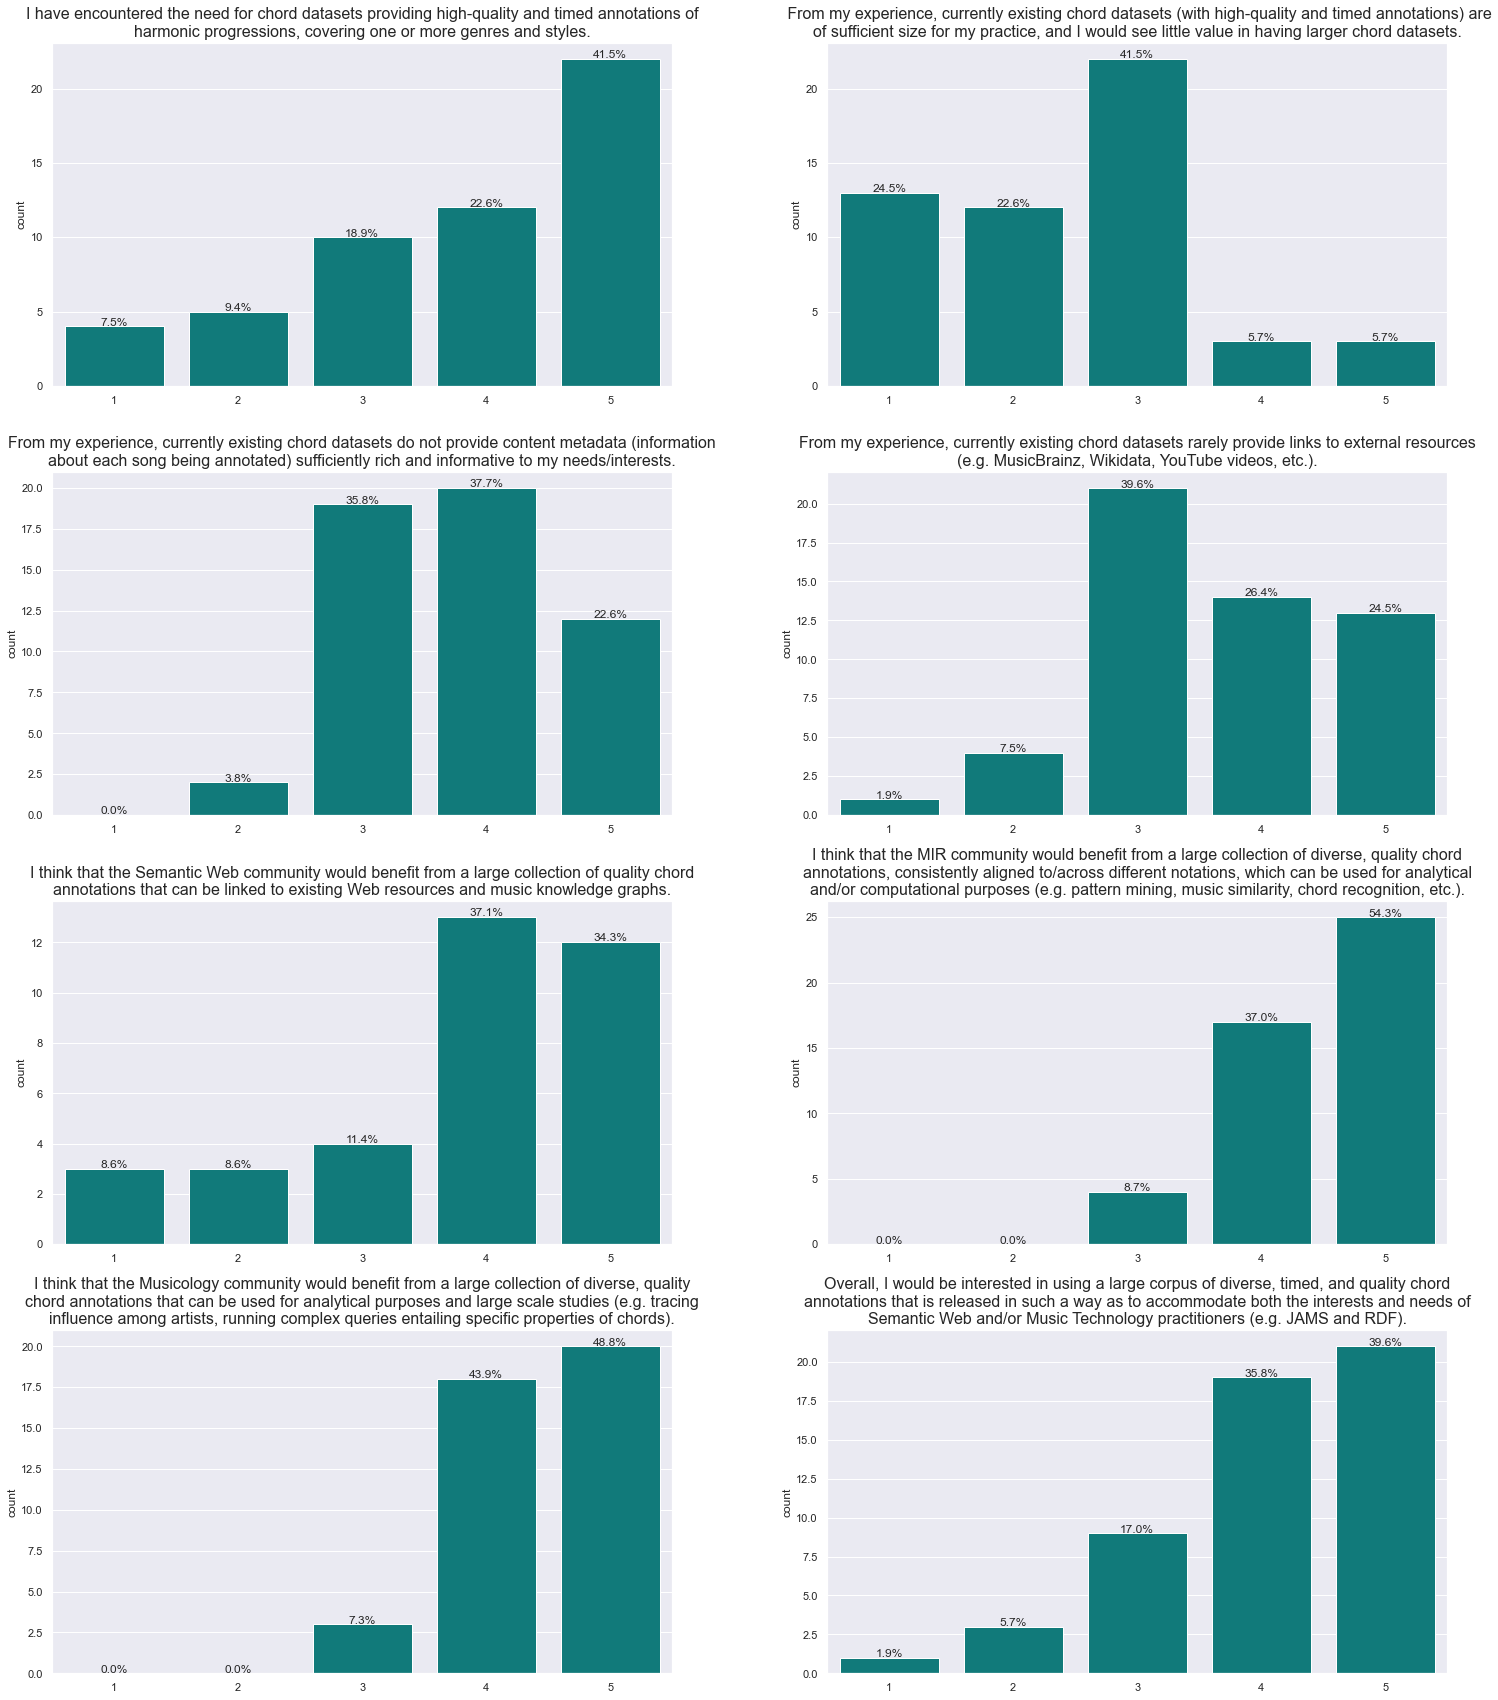

In [19]:
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(25, 30))

questions = list(survey_df.columns)
questions[10] = questions[10].replace(" in addition to their label).", ").")

for i in range(8):  # expecting 8 plots in total
    question_barplot(4+i, ax=axes[i//2, i%2], title_wrap=100)

# plt.tight_layout()
fig.subplots_adjust(wspace=0.25, hspace=0.25)
plt.savefig("survey_evidence.pdf")

# Question 11 (open)

In [ ]:
q_11 = survey_df.iloc[:, -2].dropna()

In [ ]:
for participant, ans in q_11.iteritems():
    print(f"Participant {participant}: {ans}\n")

In [ ]:
with pd.option_context("max_colwidth", 10000):
    q_11.to_latex("survey_q11.tex", index=False)

In [ ]:
q_11.to_csv("survey_q11.csv", index=False)